In [2]:
rm(list=ls())
library(refund);
library(ggplot2)
library(dplyr); 
library(dplyr); 
library(reshape2); 
library(fda);
library(fdaACF)
set.seed(100)

# Table of contents: tbd

In [3]:
# set up "global" variables
n_obs = 60
n_var = 150 #number of vars
test = seq(1,20,1)
grid = seq(0, 1, length = n_var+1)
beta1 = sin(grid * 5 * pi)
beta2 = -dnorm(grid, mean=.2, sd=.03) +3*dnorm(grid, mean=.5,
sd=.04)+dnorm(grid, mean=.75, sd=.05)

nharm = 4 #number of fpc


In [4]:
data_generation <-function(){
    var1 = 1
    var2 = 5
    var3 = 0.2

    X <- matrix(0, nrow=n_obs, ncol=length(grid))
    for(i2 in 1:n_obs){
        X[i2,]=X[i2,]+rnorm(length(grid), 0, var1)
        X[i2,]=X[i2,]+runif(1, 0, var2)
        X[i2,]=X[i2,]+rnorm(1, 0, var3)*grid
        
        for(j2 in 1:10){
            e =rnorm(2, 0, var1/j2^(2))
            X[i2,]=X[i2,]+e[1]*sin((2*pi)*grid*j2)
            X[i2,]=X[i2,]+e[2]*cos((2*pi)*grid*j2)
        }
        
    }
    return(X)
    
    # # This is a "more clear" setup

    # X <- matrix(0, nrow=n_obs, ncol=length(grid))
    # for(i2 in 1:n_obs){
    #     X[i2,]=X[i2,]+rnorm(length(grid), 0, var1)
    #     X[i2,]=X[i2,]+runif(1, 0, var2)
    #     X[i2,]=X[i2,]+rnorm(1, 0, var3)*grid
        
    #     e=abs(rnorm(2, 0, 1**(2)))
    #     X[i2,]=X[i2,]+e[1]*sin((2*pi)*grid)
    #     X[i2,]=X[i2,]+e[2]*cos((2*pi)*grid)
        
        
        
    # }
    # return(X)

}


[1] "done"

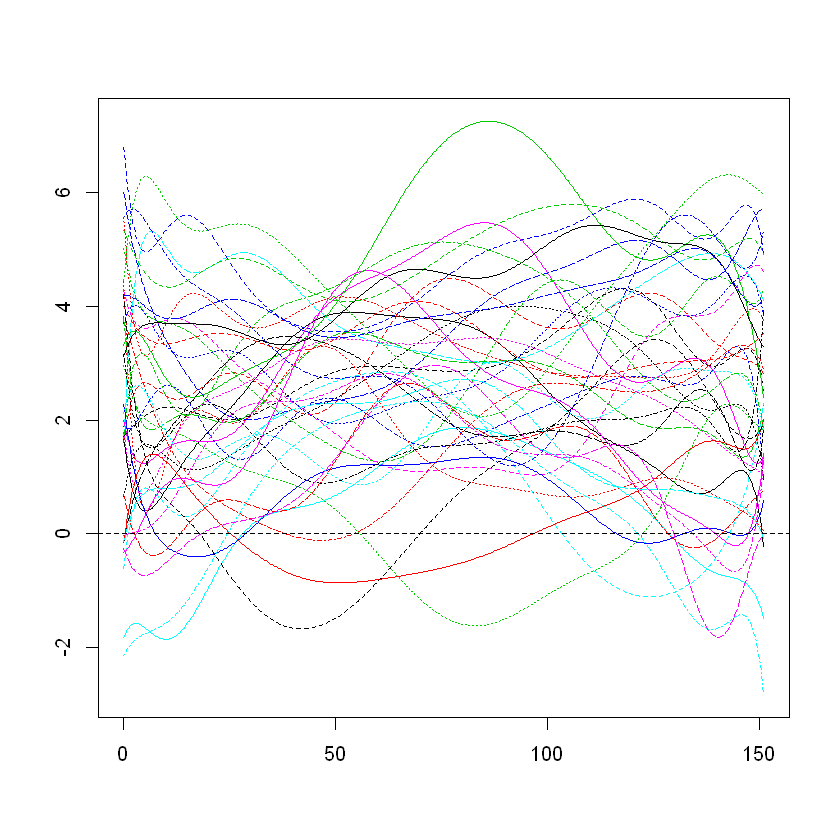

In [5]:
X = data_generation()
Y = X %*% beta1*(1/n_var)  + rnorm(n_obs, 0, 0.125) 
Y = as.numeric(Y)
final_X = t(X)
X_train = final_X[,-test]
Y_train = Y[-test]
X_test = final_X[,test]
Y_test = Y[test]
 # transpose, st obsverations now in columns // 
#todo: check if dim correct 

smallbasis  <- create.bspline.basis(rangeval = c(0, length(grid)), nbasis = 12, 7)
#harmFdpar = fdPar(smallbasis)

smooth_basis_train <- smooth.basis(y = X_train, fdParobj=smallbasis)
smooth_basis_train_fd = smooth_basis_train$fd
smooth_basis_test <- smooth.basis(y = X_test, fdParobj=smallbasis)
smooth_basis_test_fd = smooth_basis_test$fd


# todo:use to choose appropriate level of explained variance

plot(smooth_basis_train_fd, ylab="", xlab="",col="gray")

[1] "done"

[1] 0.03434265


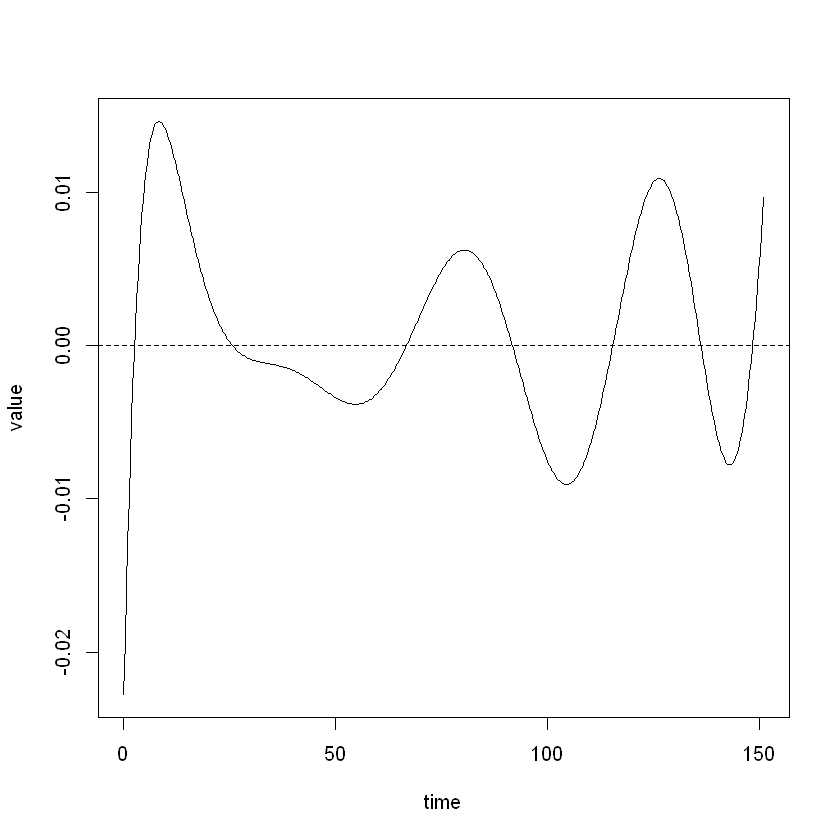

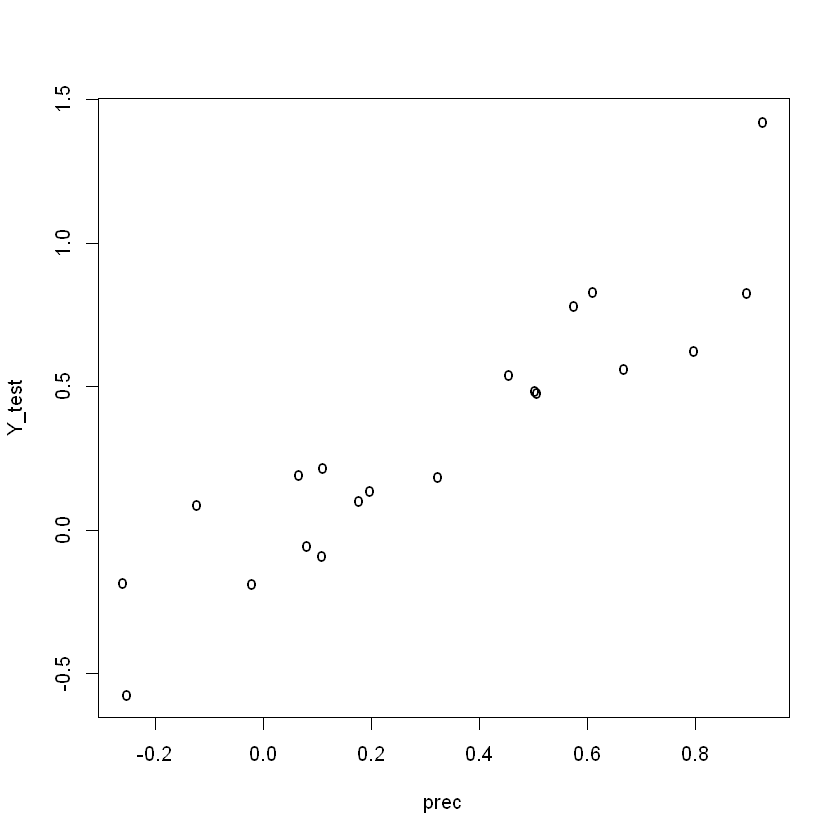

In [78]:
xfdlist = list( smooth_basis=smooth_basis_train_fd)
betabasis1 <- create.constant.basis(c(0, (n_obs-length(test))))
#betabasis_test <- create.constant.basis(c(0, length(test)))
betafd1    <- fd(0, betabasis1)
betafdPar1 <- fdPar(betafd1)
betafd2    <- create.bspline.basis(rangeval = c(0, n_var+1), nbasis = 12, 7)
betafdPar2  <- fdPar(betafd2)
betalist <- list(smooth_basis_fd=betafdPar2)


#cMap = smooth_basis_train$y2cMap # a matrix that contains the linear transformation that takes the raw data values into the coefficients defining a smooth functional data object
# cMpa can be added to f_regress
f_regress <- fRegress(y = Y_train, xfdlist, betalist, y2cMap = smooth_basis_train$y2cMap)
# also possible to use formula interface:
f_regress2 <- fRegress(Y_train ~ smooth_basis_train_fd)
prec <- predict.fRegress(object = f_regress, 
                newdata = list(data = smooth_basis_test_fd))

# #  plot the data and the fit
plot(f_regress2$betaestlist[[2]])
MSE_test <- mean((Y_test-prec)^2)
print(MSE_test)
plot(prec, Y_test, type="p", pch="o")


In [81]:
# construct standart errors!
# negative stderr???
res = c((Y_train - predict(f_regress))^2)
SigmaE = diag(res, 40) 
y2cMap = smooth_basis_train$y2cMap
std_err = fRegress.stderr(f_regress, y2cMap, SigmaE, TRUE)
std_err$betastderrlist


[[1]]
$coefs
                  [,1]
bspl7.1   0.0092149831
bspl7.2   0.0113212852
bspl7.3  -0.0011157875
bspl7.4   0.0068090783
bspl7.5  -0.0010576111
bspl7.6   0.0053003111
bspl7.7  -0.0008179632
bspl7.8   0.0051322279
bspl7.9   0.0009484147
bspl7.10  0.0066306466
bspl7.11  0.0013577905
bspl7.12  0.0178966159

$basis
$call
basisfd(type = type, rangeval = rangeval, nbasis = nbasis, params = params, 
    dropind = dropind, quadvals = quadvals, values = values, 
    basisvalues = basisvalues)

$type
[1] "bspline"

$rangeval
[1]   0 151

$nbasis
[1] 12

$params
[1]  25.16667  50.33333  75.50000 100.66667 125.83333

$dropind
NULL

$quadvals
NULL

$values
list()

$basisvalues
list()

$names
 [1] "bspl7.1"  "bspl7.2"  "bspl7.3"  "bspl7.4"  "bspl7.5"  "bspl7.6" 
 [7] "bspl7.7"  "bspl7.8"  "bspl7.9"  "bspl7.10" "bspl7.11" "bspl7.12"

attr(,"class")
[1] "basisfd"

$fdnames
$fdnames$time
  [1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  

## Trying to calculate confidence intervals, but our models miss betastderrlist, which s needed to calculate fregress.stderr

## Tryto replicate from https://github.com/cran/fda/blob/master/demo/weatherANOVA.R line 62 ff

## FPCR

[1] 0.891236508 0.068136586 0.028276740 0.003312739

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.026382301,0.049258693,0.5355867,5.956315e-01
data1,0.009376638,0.001393627,6.7282274,8.592320e-08
data2,0.018050198,0.002421106,7.4553530,9.969536e-09
data3,0.003641302,0.003618794,1.0062198,3.212160e-01
data4,-0.003684204,0.010584526,-0.3480745,7.298691e-01


[1] "done"

ERROR: Error in fdParcheck(fdParobj): 'fdPar' is not a functional parameter object, not a functional data object, and not a basis object.


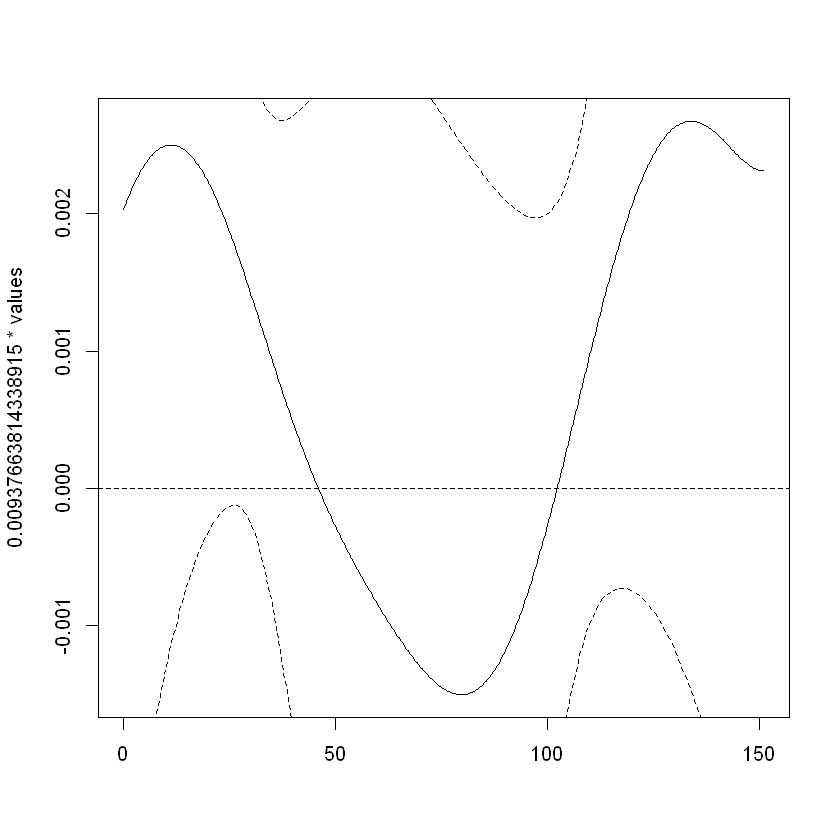

In [58]:

simulated_pcaObj_train = pca.fd(smooth_basis_train_fd, nharm = nharm,  centerfns = FALSE)
simulated_pcaObj_test = pca.fd(smooth_basis_test_fd, nharm = nharm, centerfns = FALSE)


# use eigenbasis of tainig set to construct 

simulated_pcaObj_train$varprop 

data = simulated_pcaObj_train$scores
f_regress_pca <- lm(Y_train ~ data)
pca_coeffs = summary(f_regress_pca)$coef
pca_coeffs

betafd = pca_coeffs[2,1]*simulated_pcaObj_train$harmonics[1] +
        pca_coeffs[3,1]*simulated_pcaObj_train$harmonics[2] + 
        pca_coeffs[4,1]*simulated_pcaObj_train$harmonics[3]+ 
        pca_coeffs[5,1]*simulated_pcaObj_train$harmonics[4]


coefvar = pca_coeffs[,2]**2

betavar = (pca_coeffs[2] * simulated_pcaObj_train$harmonics[1])**2 +
          (pca_coeffs[3] * simulated_pcaObj_train$harmonics[2])**2 +
          (pca_coeffs[4] * simulated_pcaObj_train$harmonics[3])**2 + 
          (pca_coeffs[5] * simulated_pcaObj_train$harmonics[4])**2

        #   This all has to become flexible! S.t we can choose the desired components that explain a
        #   certain amount of the variance and then this will become dynamic


plot(betafd)
lines(betafd+2*sqrt(betavar), lty=2, lwd=1)
lines(betafd-2*sqrt(betavar), lty=2, lwd=1)
########################
# JAKOB HELP US!!!
########################
data = smooth.basis(y = X_test, fdParobj = simulated_pcaObj_train$scores)
prec_pca <- predict.lm(object = f_regress_pca, data.frame(data = t(data)))

MSE_test <- mean((Y_test-prec_pca)^2)
print(MSE_test)
plot(prec_pca, Y_test, type="p", pch="o")


In [59]:
test = smooth.basis(y = X_test, fdParobj = simulated_pcaObj_train$scores)
summary(test)
#simulated_pcaObj_train$scores

ERROR: Error in fdParcheck(fdParobj): 'fdPar' is not a functional parameter object, not a functional data object, and not a basis object.


[1] "done"

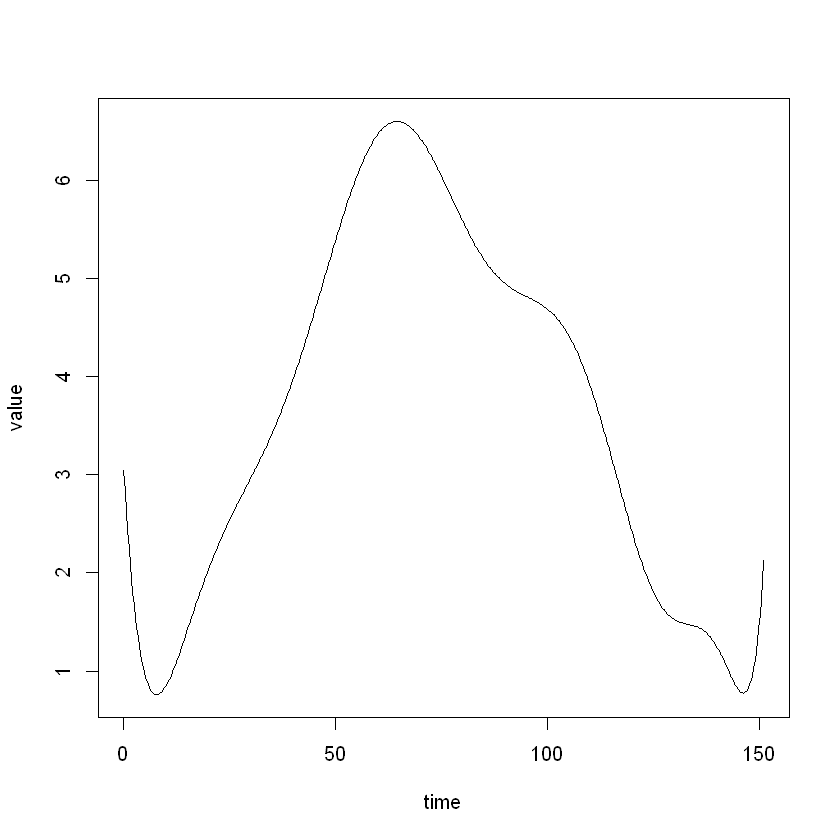

[1] "done"

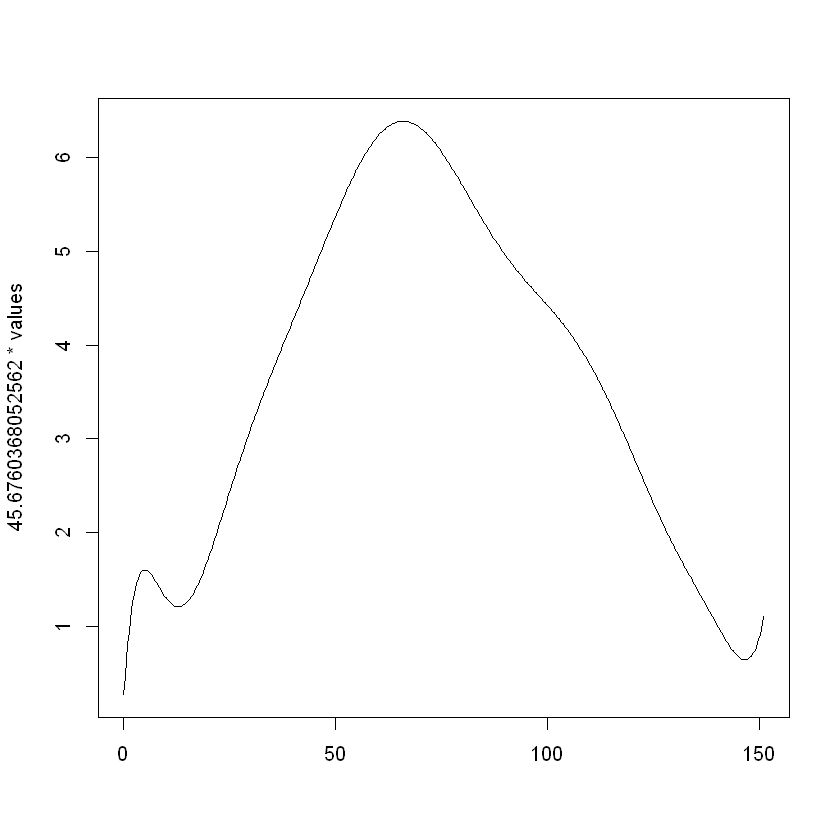

In [35]:
fd_rec = reconstruct_fd_from_PCA(simulated_pcaObj_test, simulated_pcaObj_test$scores[1,], centerfns= FALSE)
plot(smooth_basis_test_fd[1])
plot(fd_rec, add = TRUE, col = "red")

In [129]:
fit <- fpcr(Y_train, fdobj = smooth_basis_train_fd ,ncomp = 4)
refund_coeffs = fit$coefficient[2:5]
#plot(fit)


In [130]:
#manually calculate the predictions
a = 0.037941820
a_refund = -0.0898585271797045
matrix(simulated_pcaObj_test$scores, ncol = 4) %*% pca_coeffs[2:5,1] + a
matrix(simulated_pcaObj_test$scores, ncol = 4) %*% refund_coeffs + a_refund

0.5152955248
0.8059169441
-0.1951727337
-0.4793935427
-0.6737135929
0.2201111372
-0.2009622298
0.4423741530
-0.8551098239
-1.2226525314
0.7641808338


-0.072770670
-0.055810246
-0.194771996
-0.224814348
-0.126862251
-0.082121220
-0.109502220
-0.133209246
-0.151457644
-0.234929107
-0.078711375


XX0.tr             X             X             X             X 
-0.0898585272 -0.0006780577  0.0024631865  0.0063594240  0.0008485888

(Intercept)        data1        data2        data3        data4 
 0.037941820 -0.004974115 -0.015200735  0.058482056 -0.012891188

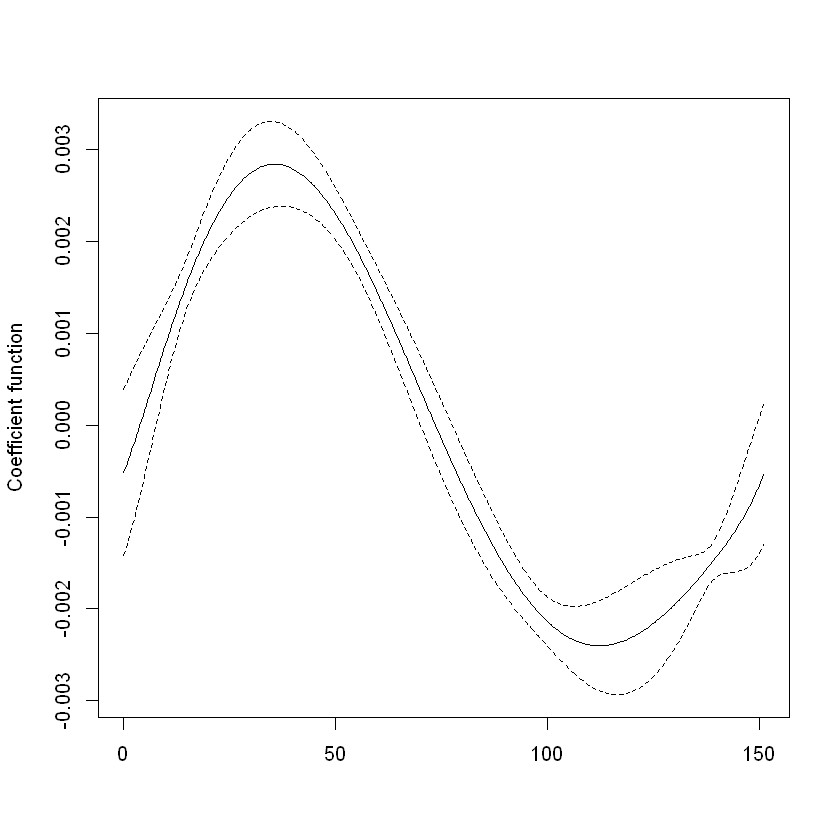

In [8]:
result_df5k <- rep(0,5)
result_df10k <- c()
n_basis <- seq(5,18,1)
n_order <- seq(3,5,1)

# First, use the old DGP


    
    for (order in n_order) {
        for (basis in n_basis) {
            for(i in 1:5){
                X = data_generation()
                Y = X %*% beta1*(1/n_var)  + rnorm(n_obs, 0, 0.125) 
                Y = as.numeric(Y)
                final_X = t(X)
                X_train = final_X[,-test]
                Y_train = Y[-test]
                X_test = final_X[,test]
                Y_test = Y[test]




                smallbasis  <- create.bspline.basis(rangeval = c(0, length(grid)), nbasis = basis, order)
                smooth_basis_train <- smooth.basis(y = X_train, fdParobj=smallbasis)
                smooth_basis_train_fd = smooth_basis_train$fd
                smooth_basis_test <- smooth.basis(y = X_test, fdParobj=smallbasis)
                smooth_basis_test_fd = smooth_basis_test$fd

                xfdlist = list(const=rep(1, (n_obs-length(test))), smooth_basis=smooth_basis_train_fd)
                # also possible to use formula interface:
                f_regress <- fRegress(Y_train ~ smooth_basis_train_fd)
                prec <- predict.fRegress(object = f_regress, 
                                newdata = list(const = fd(matrix(rep(1, length(test)), 1, length(test)), betabasis_test), 
                                            data = smooth_basis_test_fd))

                # #  plot the data and the fit
                #plot(f_regress$betaestlist[[2]])
                MSE_test <- mean((Y_test-prec)^2)
                result_df5k[i] = MSE_test
                print(MSE_test)
                #plot(prec, Y_test, type="p", pch="o")
            }
            print(mean(result_df5k))
       

        # result  <- cbind("k fold" = k , "OLS MSE" = MSE_OLS, "Ridge MSE" = cv.ridge.mse, "Lasso MSE" = cv.Lasso.mse,
        #                  "PCR MSE" = MSE_PCR_m.opt, "lam_r" = cv.ridge.lambda,
        #                  "lam_l" = cv.lasso.lambda, "M" = pcr_fit_cv$m.opt)
    
        
        # if(result[1]==k_folds[1]){
        #     result_df5k <- rbind(result_df5k, result)
        # }
        # else{
        #     result_df10k <- rbind(result_df10k, result)
        # }    

      }
}

rownames(result_df5k) <- NULL
rownames(result_df10k) <- NULL
head(result_df5k)
head(result_df10k)


[1] 0.02439768
[1] 1.218551
[1] 0.3416415
[1] 0.6060228
[1] 0.1720022
[1] 0.4725229
[1] 0.8167978
[1] 0.7743047
[1] 0.3635702
[1] 0.5308662
[1] 0.8649244
[1] 0.6700927
[1] 1.39344
[1] 4.806067
[1] 0.5916123
[1] 0.09525825
[1] 0.06855936
[1] 1.390988
[1] 1.327498
[1] 0.6739535
[1] 0.3142694
[1] 0.7411552
[1] 0.02371503
[1] 0.6161182
[1] 0.1450369
[1] 1.646986
[1] 0.1379426
[1] 0.0452561
[1] 0.3644257
[1] 0.4679294
[1] 0.5372235
[1] 1.915261
[1] 0.5530702
[1] 1.882001
[1] 0.61311
[1] 1.100133
[1] 0.3910934
[1] 0.2858016
[1] 0.03801365
[1] 0.09359407
[1] 0.627959
[1] 0.2872923
[1] 0.1037661
[1] 1.671142
[1] 1.121344
[1] 1.066741
[1] 0.4726383
[1] 0.8871261
[1] 1.38387
[1] 1.747578
[1] 1.438228
[1] 0.1727895
[1] 0.01829094
[1] 0.9521513
[1] 0.2915293
[1] 0.3723958
[1] 0.03887944
[1] 0.2578361
[1] 0.5820444
[1] 0.308537
[1] 0.9391563
[1] 2.373382
[1] 0.4126493
[1] 0.0715966
[1] 12.70236
[1] 3.299828
[1] 0.6499065
[1] 1.717563
[1] 0.01418814
[1] 0.04055793
[1] 0.5690363
[1] 0.5982504
[1] 0.6

[1] 2.41272233 1.45327287 0.02809849 1.60356153 0.71086274

NULL